## Importando bibliotecas necessárias

- *Hydrograph-py* para separar o fluxo de base a partir da série temporal de vazão

In [1]:
import pandas as pd
import geopandas as gpd
from Hydrograph.hydrograph import sepBaseflow
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# Configurações do pandas
pd.options.mode.chained_assignment = None    # default='warn'  --> opção None

## Lendo os arquivos (.csv) de vazão e os limites da bacia em .geojson

In [3]:
#Diretório para leitura de arquivos e salvamento de resultados

# bacia = 'atibaia_cabeceira'
# bacia = 'camanducaia'
# bacia = 'capivari'
bacia = 'corumbatai'
# bacia = 'jundiai'


path = 'D:/projetos_qswatmod/' + f'{bacia}' + '/outputs/'
results_path = 'D:/projetos_qswatmod/' + f'{bacia}' + '/esc_superficial/'

In [4]:
#Dados de vazão
df = pd.read_csv(path + 'vazao.csv')

#Camada vetorial dos limites da referida bacia hidrográfica
boundaries = gpd.read_file(path + 'boundary.geojson')

## Dados da bacia

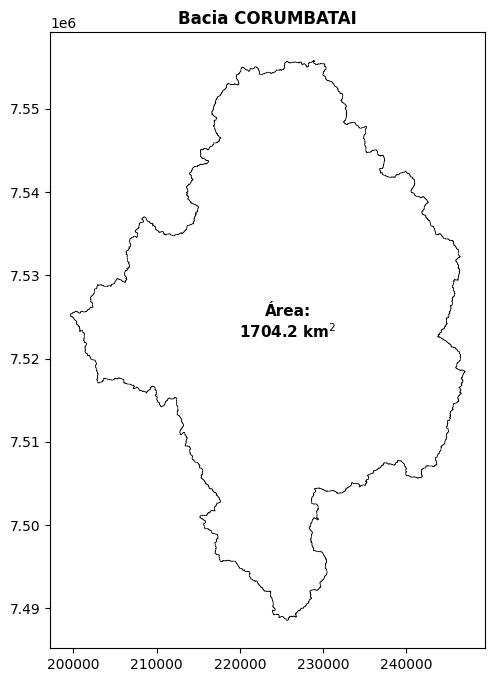

In [5]:
#Calculando a área da bacia em km^2
boundaries['area_km2'] = boundaries['geometry'].area / 10**6
area_bacia_km2 = boundaries.loc[0, 'area_km2']

#Calculando as coordenadas do centroide do polígono
boundaries['x'] = boundaries['geometry'].centroid.x
boundaries['y'] = boundaries['geometry'].centroid.y
x_coord = boundaries.loc[0, 'x']
y_coord = boundaries.loc[0, 'y']

#Plotando os limites da bacia hidrográfica
fig, ax1 = plt.subplots(figsize=(8, 8))

boundaries.boundary.plot(ax=ax1, color='k', lw=0.5, ls='-')

ax1.set_title(f'Bacia {bacia.upper()}', fontsize=12, color='k', weight='bold')
ax1.text(x_coord, y_coord, f'Área:\n{area_bacia_km2:.1f} km$^{2}$', va='center', ha='center', color='k', fontsize=11, fontweight='bold', bbox=dict(facecolor='w', alpha=0.6, edgecolor='w', ls='-'))    # transform=ax1.transAxes


plt.show()

## Análise dos dados

In [7]:
#Verificando o tipo das colunas
df.dtypes

Date     object
Qobs    float64
dtype: object

In [ ]:
#Renomeando as colunas conforme instruções da documentação da biblioteca Hydrograph-py
df.rename(columns={'Date': 'Date',
                   'Qobs': 'Total runoff [m^3 s^-1]'}, inplace=True)

df.head()

,Date,Total runoff [m^3 s^-1]
0,01/01/1985,19.513
1,01/02/1985,15.230
2,01/03/1985,12.898
3,01/04/1985,11.395
4,01/05/1985,11.767


In [9]:
#Convertendo a coluna "Date" para o tipo datetime64
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
#Conferindo o tipo das colunas
df.dtypes

Date                       datetime64[ns]
Total runoff [m^3 s^-1]           float64
dtype: object

In [11]:
#A coluna "Date" deve ser um datetime index do pandas
df.set_index('Date', inplace=True)

df.head()

,Total runoff [m^3 s^-1]
Date,
1985-01-01,19.513
1985-01-02,15.230
1985-01-03,12.898
1985-01-04,11.395
1985-01-05,11.767


In [12]:
#Selecionar um período caso necessário
# df = df.loc['1997-01-01': '2002-12-31']

In [13]:
#Conferindo o df resultante
df

,Total runoff [m^3 s^-1]
Date,
1985-01-01,19.513
1985-01-02,15.230
1985-01-03,12.898
1985-01-04,11.395
1985-01-05,11.767
...,...
2019-12-27,12.483
2019-12-28,11.785
2019-12-29,11.103


In [14]:
#Verifincando se há falhas na série de vazão
falhas = df['Total runoff [m^3 s^-1]'].isna().sum()
print(f'Falhas: {falhas}')

Falhas: 0


In [15]:
#Obtendo o ano inicial, final e período de dados
ano_min = df.index.min().year
ano_max = df.index.max().year
periodo = (ano_max - ano_min) + 1

print(f'De {ano_min} a {ano_max} | {periodo} ano(s)')

De 1985 a 2019 | 35 ano(s)


In [16]:
"""
Os valores do parâmetro k para cada sub-bacia PCJ foram ajustados individualmente
utilizando a metodologia apresentado no cap 1.
"""

if bacia == 'atibaia_cabeceira':
    k = 0.00002
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')
elif bacia == 'camanducaia':
    k = 0.000025
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')
elif bacia == 'capivari':
    k = 0.000064
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')
elif bacia == 'corumbatai':
    k = 0.000025
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')
else:
    k = 0.000008
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')

Bacia: CORUMBATAI
Área (km^2): 1704.23
k: 2.5e-05


## Executando a função *sepBaseflow*

In [ ]:
df2 = sepBaseflow(df, 60, Area, k, dt_max=24, tp_min=6)

In [18]:
#Cópia do df para análises posteriores
df3 = df2.copy(deep=True)

In [19]:
#Seleção das colunas (variáveis) desejadas e renoameando-as para termos mais simples
df3 = df3.loc[:, ['Total runoff [m^3 s^-1]', 'Baseflow [m^3 s^-1]', 'Peakflow [m^3 s^-1]']]
df3.rename(columns={'Total runoff [m^3 s^-1]': 'Vazao_cms',
                    'Baseflow [m^3 s^-1]': 'Fluxo_base_cms',
                    'Peakflow [m^3 s^-1]': 'Esc_superficial_cms'}, inplace=True)


df3

,Vazao_cms,Fluxo_base_cms,Esc_superficial_cms
Date,,,
1985-01-01 00:00:00,19.513,19.513000,0.0
1985-01-01 01:00:00,NaN,19.334542,0.0
1985-01-01 02:00:00,NaN,19.156083,0.0
1985-01-01 03:00:00,NaN,18.977625,0.0
1985-01-01 04:00:00,NaN,18.799167,0.0
...,...,...,...
2019-12-30 20:00:00,NaN,9.894333,0.0
2019-12-30 21:00:00,NaN,9.867250,0.0
2019-12-30 22:00:00,NaN,9.840167,0.0


In [20]:
#Remostragem para escala diária
df3 = df3.resample('D').agg({'Vazao_cms': 'mean',
                             'Fluxo_base_cms': 'mean',
                             'Esc_superficial_cms': 'mean'})

df3

,Vazao_cms,Fluxo_base_cms,Esc_superficial_cms
Date,,,
1985-01-01,19.513,17.460729,0.000000
1985-01-02,15.230,14.112583,0.000000
1985-01-03,12.898,12.177812,0.000000
1985-01-04,11.395,11.573250,0.000000
1985-01-05,11.767,12.256966,0.051971
...,...,...,...
2019-12-27,12.483,12.148542,0.000000
2019-12-28,11.785,11.458208,0.000000
2019-12-29,11.103,10.783396,0.000000


## Visualizando

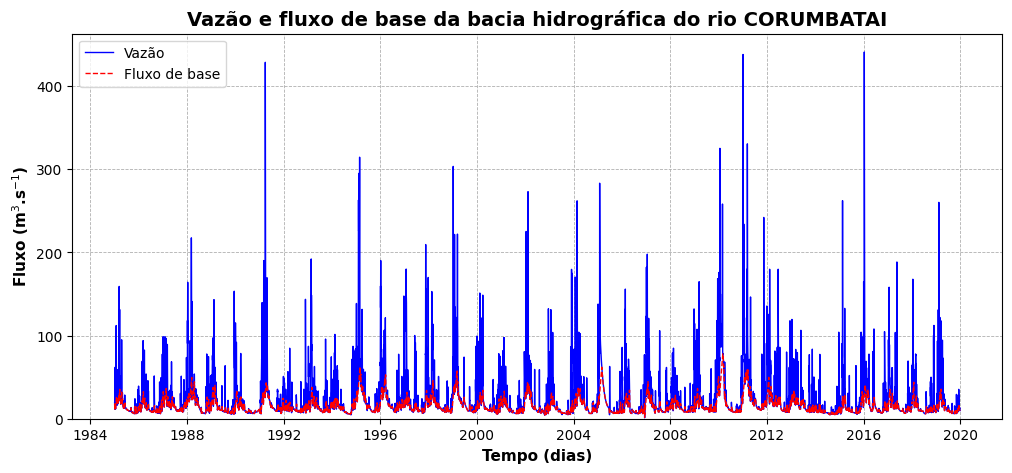

In [21]:
#Configurando a figura
plt.figure(figsize=(12, 5))

#Plotando vazão e fluxo de base
plt.plot(df3.index, df3['Vazao_cms'], color='blue', lw=1.0, ls='-', label='Vazão')
plt.plot(df3.index, df3['Fluxo_base_cms'], color='red', lw=1.0, ls='--', label='Fluxo de base')

#Demais elementos do gráfico
plt.title(f'Vazão e fluxo de base da bacia hidrográfica do rio {bacia.upper()}', fontsize=14, color='k', weight='bold')
plt.ylabel('Fluxo (m$^{3}$.s$^{-1}$)', fontsize=11, color='k', weight='bold')
plt.xlabel('Tempo (dias)', fontsize=11, color='k', weight='bold')
plt.ylim(0, None)
plt.legend()
plt.grid(True, lw=0.6, ls='--')


# plt.xlim(dt.datetime(2005, 1, 1), dt.datetime(2005, 12, 31))    # Para filtrar um determinado período no gráfico

plt.show()

## Processamento para gerar a série de escoamento superficial

In [29]:
df3.head()

,Vazao_cms,Fluxo_base_cms,Esc_superficial_cms
Date,,,
1985-01-01,19.513,17.460729,0.000000
1985-01-02,15.230,14.112583,0.000000
1985-01-03,12.898,12.177812,0.000000
1985-01-04,11.395,11.573250,0.000000
1985-01-05,11.767,12.256966,0.051971


In [30]:
esc_sup = df3.copy(deep=True)
esc_sup = esc_sup.resample('MS').mean()
cols = ['Esc_superficial_cms']
esc_sup = esc_sup[cols]
esc_sup.reset_index('Date', inplace=True)
esc_sup.rename(columns={'Date': 'Data',
                        'Esc_superficial_cms': 'Esc. superficial (m^3/s)'}, inplace=True)

esc_sup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Data                      420 non-null    datetime64[ns]
 1   Esc. superficial (m^3/s)  420 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.7 KB


In [31]:
esc_sup

,Data,Esc. superficial (m^3/s)
0,1985-01-01,19.389077
1,1985-02-01,9.418991
2,1985-03-01,24.982001
3,1985-04-01,10.610419
4,1985-05-01,0.618199
...,...,...
415,2019-08-01,0.130232
416,2019-09-01,0.557473
417,2019-10-01,0.465534
418,2019-11-01,2.207479


In [32]:
area_bacia_m2 = area_bacia_km2 * 10 ** 6

print(f'Área da bacia (m^2): {round(area_bacia_m2, 1)}')

Área da bacia (m^2): 1704231000.0


In [33]:
#Conversão do escoamento superficial de m^3/s para mm/dia
area_bacia_m2 = area_bacia_km2 * 10 ** 6
esc_sup['Esc. superficial (mm/dia)'] = esc_sup.apply((lambda x: (x['Esc. superficial (m^3/s)'] / area_bacia_m2) * (1000 * 3600 * 24 * 30.42)), axis=1)  # conferir unidade dessa col

esc_sup

,Data,Esc. superficial (m^3/s),Esc. superficial (mm/dia)
0,1985-01-01,19.389077,29.902095
1,1985-02-01,9.418991,14.526095
2,1985-03-01,24.982001,38.527578
3,1985-04-01,10.610419,16.363531
4,1985-05-01,0.618199,0.953394
...,...,...,...
415,2019-08-01,0.130232,0.200846
416,2019-09-01,0.557473,0.859743
417,2019-10-01,0.465534,0.717953
418,2019-11-01,2.207479,3.404403


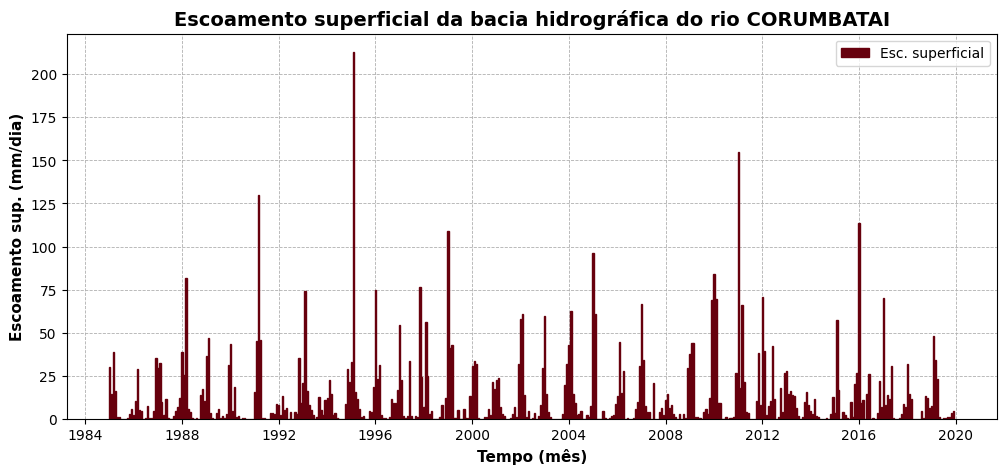

In [34]:
#Configurando a figura
plt.figure(figsize=(12, 5))

plt.bar(esc_sup['Data'], esc_sup['Esc. superficial (mm/dia)'], width=20, color='#67000D', edgecolor='#67000D', label='Esc. superficial', zorder=2)

#Demais elementos do gráfico
plt.title(f'Escoamento superficial da bacia hidrográfica do rio {bacia.upper()}', fontsize=14, color='k', weight='bold')
plt.ylabel('Escoamento sup. (mm/dia)', fontsize=11, color='k', weight='bold')
plt.xlabel('Tempo (mês)', fontsize=11, color='k', weight='bold')
plt.ylim(0, None)
plt.legend()
plt.grid(True, lw=0.6, ls='--')

#Visualizando
plt.show()